In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import arviz as az
from cycler import cycler

from sphincter.data_preparation import load_prepared_data
from sphincter.plotting import plot_obs, plot_predictive, save_figure


CMAP = plt.get_cmap('Set2')

plt.rcParams['axes.prop_cycle'] = cycler(color=CMAP.colors)

In [2]:
abbreviations = {
    "post_ablation": "post abl.",
}

def format_name(name: str):
    return name.replace("_", " ").capitalize()


In [28]:
def forestplot(ax, ts, xlabel="Distribution of posterior samples"):
    az.plot_forest(ts, ax=ax, combined=True, textsize=12, linewidth=3);
    ax.axvline(0.0, linestyle="--", color="black");
    xlow, xhigh = ax.get_xlim();
    xbiggest = max(abs(xlow), abs(xhigh))
    ax.set_xlim(-xbiggest, xbiggest);
    ax.set(title="", xlabel=xlabel);
    return ax

### MAP, PP, HR (Figure 1)

In [4]:
idata_f1 = az.InferenceData.from_zarr(os.path.join("..", "inferences", "pressure", "idata"))

In [7]:
idata_f1

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> sample_stats_prior
	> observed_data

In [17]:
idata_f1.posterior.coords["treatment"].values

array(['baseline', 'hyper1', 'after_hyper1', 'ablation', 'hyper2'],
      dtype='<U12')

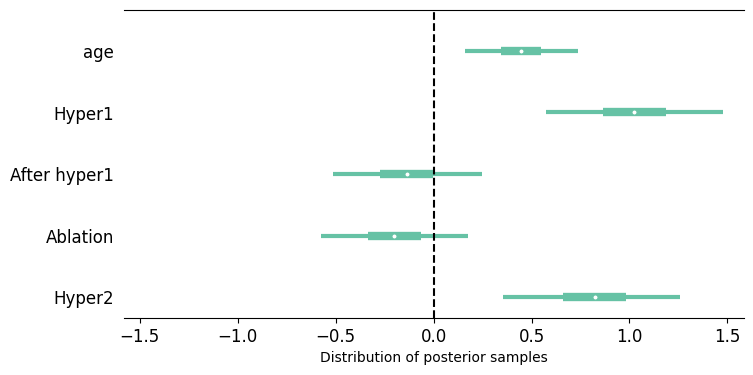

In [21]:
measurement_type = "map"
vcb = [
    ("a_age", "age", "adult"),
    ("a_treatment", "treatment", "baseline")
]
age_ts = {
    "age": idata_f1.posterior["a_age"].sel(measurement_type=measurement_type, age="adult") 
    - idata_f1.posterior["a_age"].sel(measurement_type=measurement_type, age="old")
}
treatment_ts = {
    format_name(treatment): idata_f1.posterior["a_treatment"].sel(measurement_type=measurement_type, treatment=treatment) 
    - idata_f1.posterior["a_treatment"].sel(measurement_type=measurement_type, treatment="baseline")
    for treatment in idata_f1.posterior.coords["treatment"].values if treatment != "baseline"
}
ts = age_ts | treatment_ts

f, ax = plt.subplots(figsize=[8, 4])
forestplot(ax, ts);
save_figure(f, "supporting-f1-effects-map")

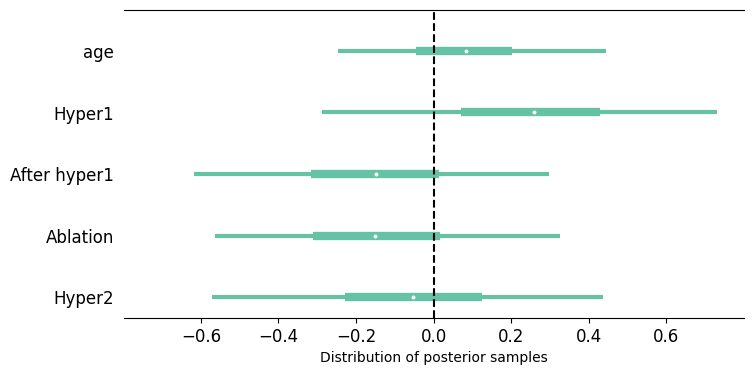

In [22]:
measurement_type = "pp"
vcb = [
    ("a_age", "age", "adult"),
    ("a_treatment", "treatment", "baseline")
]
age_ts = {
    "age": idata_f1.posterior["a_age"].sel(measurement_type=measurement_type, age="adult") 
    - idata_f1.posterior["a_age"].sel(measurement_type=measurement_type, age="old")
}
treatment_ts = {
    format_name(treatment): idata_f1.posterior["a_treatment"].sel(measurement_type=measurement_type, treatment=treatment) 
    - idata_f1.posterior["a_treatment"].sel(measurement_type=measurement_type, treatment="baseline")
    for treatment in idata_f1.posterior.coords["treatment"].values if treatment != "baseline"
}
ts = age_ts | treatment_ts

f, ax = plt.subplots(figsize=[8, 4])
forestplot(ax, ts);
save_figure(f, "supporting-f1-effects-pp")

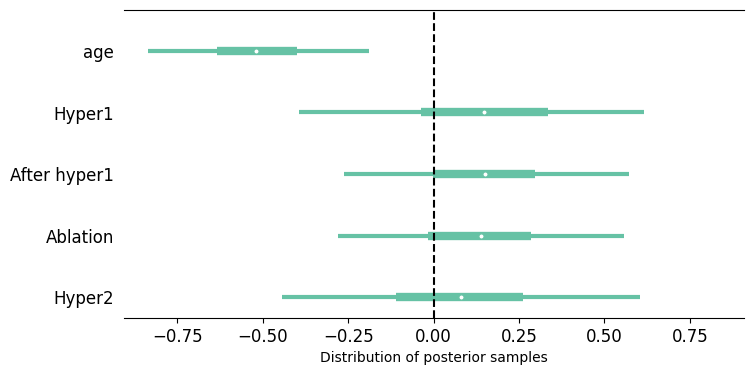

In [29]:
measurement_type = "hr"
vcb = [
    ("a_age", "age", "adult"),
    ("a_treatment", "treatment", "baseline")
]
age_ts = {
    "age": idata_f1.posterior["a_age"].sel(measurement_type=measurement_type, age="adult") 
    - idata_f1.posterior["a_age"].sel(measurement_type=measurement_type, age="old")
}
treatment_ts = {
    format_name(treatment): idata_f1.posterior["a_treatment"].sel(measurement_type=measurement_type, treatment=treatment) 
    - idata_f1.posterior["a_treatment"].sel(measurement_type=measurement_type, treatment="baseline")
    for treatment in idata_f1.posterior.coords["treatment"].values if treatment != "baseline"
}
ts = age_ts | treatment_ts

f, ax = plt.subplots(figsize=[8, 4])
forestplot(ax, ts);
save_figure(f, "supporting-f1-effects-hr")

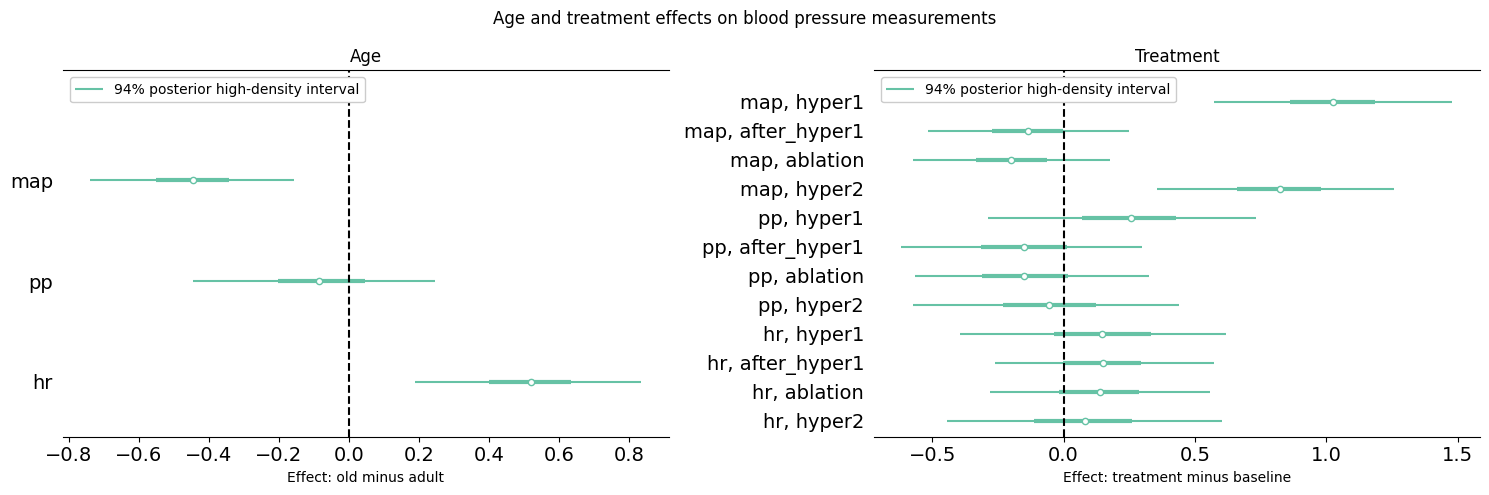

In [6]:
f, axes = plt.subplots(1, 2, figsize=[15, 5])

vcb = [
    ("a_age", "age", "adult"),
    ("a_treatment", "treatment", "baseline")
]

for (var, coord, baseline), ax in zip(vcb, axes):
    t = (
        idata_f1.posterior[var] - idata_f1.posterior[var].sel(**{coord: baseline})
    ).sel(**{coord: [c for c in idata_f1.posterior.coords[coord].to_numpy() if c != baseline]})
    az.plot_forest(t, combined=True, ax=ax, labeller=az.labels.NoVarLabeller())
    ax.set(title=coord.capitalize())
    ax.axvline(0.0, linestyle="--", color="black")
    ax.legend([ax.collections[0]], ["94% posterior high-density interval"], framealpha=1.0, loc="upper left")
axes[0].set(xlabel="Effect: old minus adult") 
axes[1].set(xlabel="Effect: treatment minus baseline")
f.suptitle("Age and treatment effects on blood pressure measurements")
f.tight_layout()
save_figure(f, "pressure-results")

### Whisker stimulation (Figure 2)

In [ ]:
idatas = {
    "whisker-ind": az.InferenceData.from_zarr(os.path.join("..", "inferences", "whisker-ind", "idata")),
    "whisker-big": az.InferenceData.from_zarr(os.path.join("..", "inferences", "whisker-big", "idata")),
}
idatas["whisker-ind"]

In [ ]:
t = idatas["whisker-ind"].posterior["mu"].sel(age="adult") - idatas["whisker-ind"].posterior["mu"].sel(age="old")

f, ax = plt.subplots()
forestplot(ax, {"Difference in age effect: adult - old": t});